<a href="https://colab.research.google.com/github/Jaesu26/dacon-basic/blob/main/2023-01-30-%EC%9D%8C%EC%95%85%EC%9E%A5%EB%A5%B4%EB%B6%84%EB%A5%98-private-4%EC%9C%84.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 음악 장르 분류 AI 경진대회

In [1]:
!pip install xgboost==1.7.2
!pip install lightgbm==3.3.5
!pip install catboost==1.1.1
!pip install scikit-learn==1.0.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 MB 6.1 MB/s eta 0:00:00
  Attempting uninstall: xgboost
    Found existing installation: xgboost 0.90
    Uninstalling xgboost-0.90:
      Successfully uninstalled xgboost-0.90
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 26.0 MB/s eta 0:00:00
  Attempting uninstall: lightgbm
    Found existing installation: lightgbm 2.2.3
    Uninstalling lightgbm-2.2.3:
      Successfully uninstalled lightgbm-2.2.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 12.7 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## 데이터 불러오기

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random
import warnings
import time
import os

from abc import ABCMeta, abstractmethod
from typing import List, Tuple, Callable, Any
from numpy.typing import NDArray, ArrayLike
from dataclasses import dataclass

from functools import wraps
from tqdm.auto import tqdm

warnings.filterwarnings('ignore') 

In [3]:
import google.colab

google.colab.drive.mount('/content/drive')  # 코랩과 구글드라이브 연결

Mounted at /content/drive


In [4]:
%cd  /content/drive/MyDrive/Colab Notebooks/음악-장르-분류

/content/drive/MyDrive/Colab Notebooks/음악-장르-분류


- 데이터 불러오기

In [5]:
train_path = './data/train.csv'
test_path = './data/test.csv'
submission_path = './data/sample_submission.csv'

In [6]:
df = pd.read_csv(train_path)
test = pd.read_csv(test_path)
submission = pd.read_csv(submission_path)

- 무의미한 변수 제거

In [7]:
df = df.drop('ID', axis=1)
test = test.drop('ID', axis=1)

- 기초 통계량 확인

In [8]:
df.describe()

,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration
count,25383.000000,25383.000000,25383.000000,25383.000000,25383.000000,25383.000000,25383.000000,25383.000000,25383.000000,25383.000000,25383.000000
mean,0.544519,0.642106,5.368239,0.523904,0.271701,0.178736,0.309931,0.324461,0.403999,0.503558,253.697514
std,0.242362,0.275050,3.660011,0.209811,0.276586,0.272155,0.399725,0.254626,0.286148,0.222104,103.020340
min,0.000000,0.000000,0.000000,0.000000,0.001100,0.000000,0.000000,0.000000,0.000000,0.007300,28.000000
25%,0.340500,0.410000,1.000000,0.372900,0.062950,0.003700,0.000000,0.138100,0.148000,0.322350,182.000000
50%,0.553400,0.701300,6.000000,0.538300,0.129600,0.035800,0.006500,0.200700,0.361800,0.483500,227.000000
75%,0.759900,0.895700,9.000000,0.683600,0.450200,0.237500,0.814000,0.501500,0.640800,0.659350,304.000000
max,1.000000,1.000000,11.000000,0.999500,1.000000,0.999900,1.000000,1.000000,1.000000,1.000000,897.000000


In [9]:
df.isnull().sum()

danceability        0
energy              0
key                 0
loudness            0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
duration            0
genre               0
dtype: int64

- 변수 설명

`-` ref: https://rstudio-pubs-static.s3.amazonaws.com/605426_6310b7a4245642309de94d3046b0160e.html

`-` key와 duration 변수를 제외한 수치형 변수를 0과 1사이의 값이 가진다

`-` danceability: 댄스에 적합한 정도

`-` energy: 음악이 세고 활발한 정도 (음악이 빠르고 크고 잡음이 많을수록 값이 크다)

`-` key: 음악의 키(조) (0 ~ 11)

`-` loudness: 인간이 느끼는 소리의 크기 (데시벨)

`-` speachiness: 말하는 정도 (노래 중 가사를 부르는 시간이 길수록 값이 큼)

`-` acousticness: 음향의 정도

`-` instrumentalness: 보컬이 포함되지 않은 정도 (값이 클수록 보컬이 포함되지 않을 가능성이 큼)

`-` liveness: 라이브 정도

`-` valence: 음악이 밝고 긍정적인 정도

`-` tempo: 음악의 빠르기 (beats per minute)

`-` duration: 음악 재생 시간(길이) (초)

`-` genre: 음악의 장르

## 시각화

In [10]:
sns.set_theme(style='white')

In [11]:
numeric_columns = df.columns[(df.dtypes == int) | (df.dtypes == float)]
categorical_columns = df.columns[(df.dtypes == 'object')]

- 라벨

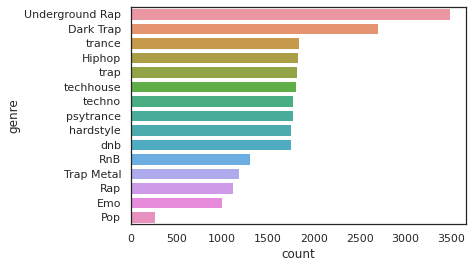

In [12]:
sns.countplot(data=df, y='genre', order=df['genre'].value_counts().index)

`-` 클래스 불균형이 존재한다

`-` 평가 산식은 `macro-f1`이므로 오버샘플링을 통해 클래스별 샘플수를 맞춰주겠다

- 양적 변수

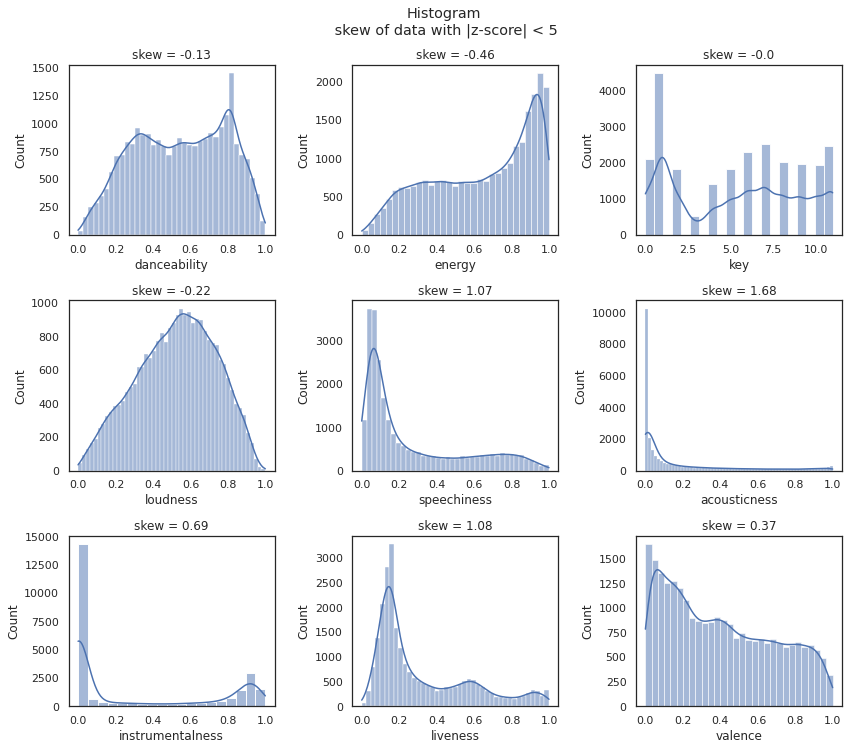

In [13]:
fig, axs = plt.subplots(3, 3, figsize=(12, 10))
for col, ax in zip(numeric_columns, axs.flatten()):
    mean, std = df[col].mean(), df[col].std()
    z_upper, z_lower = mean + 5*std, mean - 5*std
    df_ = df[(df.loc[:, col] < z_upper) & (df.loc[:, col] > z_lower)]
    skew = round(df_[col].skew(), 2)
    sns.histplot(data=df, x=col, kde=True, ax=ax)
    ax.set_title(f'skew = {skew}')

fig.suptitle('Histogram\n skew of data with |z-score| < 5', x=0.52, y=1.04)
fig.tight_layout()

`-` 변수 변환 필요: `energy`, `speechiness`, `acousticness`, `liveness`, `valence`

`-` 트리 기반 모델을 사용할 것이라면 크게 중요하지 않음

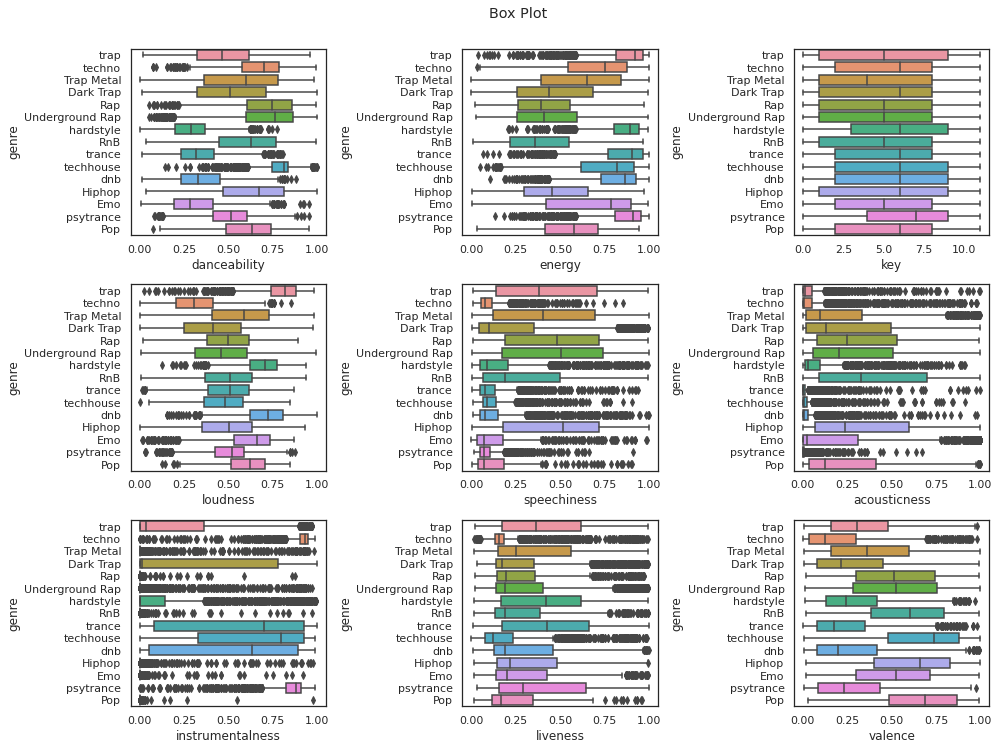

In [14]:
fig, axs = plt.subplots(3, 3, figsize=(14, 10))
target = 'genre'
for col, ax in zip(numeric_columns, axs.flatten()):
    sns.boxplot(data=df, x=col, y=target, ax=ax)

fig.suptitle('Box Plot', x=0.52, y=1.04)
fig.tight_layout()

## 훈련 및 예측

In [15]:
from scipy import stats
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import StratifiedKFold

from sklearn.metrics import f1_score

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

In [16]:
def seed_everything(seed: int = 23) -> None:
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

- 라벨 인코딩

In [17]:
label_encoder = LabelEncoder()
df['genre'] = label_encoder.fit_transform(df['genre'])

In [18]:
target = df.pop('genre')

In [19]:
target.value_counts()

7     3482
0     2696
13    1837
2     1822
14    1814
11    1809
12    1767
10    1767
9     1755
8     1749
5     1308
6     1188
4     1120
1      999
3      270
Name: genre, dtype: int64

- 정규화

In [20]:
def minmax_scaling(train_data: pd.DataFrame, test_data: pd.DataFrame) -> Tuple[pd.DataFrame, pd.DataFrame]:
    train_data, test_data = train_data.copy(), test_data.copy()
    numeric_columns = train_data.columns[(train_data.dtypes == int) | (train_data.dtypes == float)]
    scaler = MinMaxScaler()

    for col in numeric_columns:
        train_data[col] = scaler.fit_transform(train_data[[col]])
        test_data[col] = scaler.transform(test_data[[col]])
        
    return train_data, test_data

- 함수 정의

`-` ref: https://github.com/Lightning-AI/lightning/blob/master/examples/pl_loops/kfold.py

In [24]:
class BaseKFoldDataset(metaclass=ABCMeta):
    @abstractmethod
    def setup(self) -> None:
        pass

    @abstractmethod
    def setup_folds(self) -> None:
        pass

    @abstractmethod
    def setup_fold_index(self, fold_index: int) -> None:
        pass

    @abstractmethod
    def setup_fold_end(self) -> None:
        pass


@dataclass
class KFoldDataset(BaseKFoldDataset):
    X: pd.DataFrame
    y: pd.Series
    X_predict: pd.DataFrame
    use_oversampling: bool = False
    use_undersampling: bool = False
    seed: int = 2023

    def setup(self) -> None:
        self.X, self.X_predict = minmax_scaling(self.X, self.X_predict)

    def setup_folds(self, num_folds: int) -> None:
        kfold = StratifiedKFold(num_folds, shuffle=True, random_state=self.seed)
        self.splits = [split for split in kfold.split(self.X, self.y)]

    def setup_fold_index(self, fold_index: int) -> None:
        train_indices, val_indices = self.splits[fold_index]
        self.X_train, self.y_train = self.X.iloc[train_indices], self.y.iloc[train_indices]
        self.X_val, self.y_val = self.X.iloc[val_indices], self.y.iloc[val_indices]

    def setup_fold_end(self) -> None:
        if self.use_oversampling:
            value = self.y_train.value_counts().get(1)
            smote = SMOTE(sampling_strategy={3:value}, random_state=self.seed)
            self.X_train, self.y_train = smote.fit_resample(self.X_train, self.y_train)

        if self.use_undersampling:
            value = self.y_train.value_counts().get(13)
            under_sampler = RandomUnderSampler(sampling_strategy={0:value, 7:value}, random_state=self.seed)
            self.X_train, self.y_train = under_sampler.fit_resample(self.X_train, self.y_train)

    def train_data(self) -> Tuple[pd.DataFrame, pd.Series]:
        return self.X_train, self.y_train

    def val_data(self) -> Tuple[pd.DataFrame, pd.Series]:
        return self.X_val, self.y_val

    def predict_data(self) -> pd.DataFrame:
        return self.X_predict

In [25]:
class BaseSklearnModel(metaclass=ABCMeta):
    @abstractmethod
    def init_model(self) -> Any:
        pass 

    @abstractmethod
    def training_step(self, train_data: Tuple[ArrayLike, ArrayLike], val_data: Tuple[ArrayLike, ArrayLike]) -> None:
        pass

    @abstractmethod
    def validation_step(self, val_data: Tuple[ArrayLike, ArrayLike]) -> float:
        pass

    @abstractmethod
    def predict_step(self, predict_data: ArrayLike) -> NDArray[np.int]:
        pass


class SklearnClassifier(BaseSklearnModel):
    def __init__(self) -> None:
        self.model = self.init_model()

    def training_step(self, train_data: Tuple[ArrayLike, ArrayLike], val_data: Tuple[ArrayLike, ArrayLike]) -> None:
        X_train, y_train = train_data
        X_val, y_val = val_data
        self.model.fit(X_train, y_train, early_stopping_rounds=200, verbose=100, eval_set=[(X_val, y_val)])

    def validation_step(self, val_data: Tuple[ArrayLike, ArrayLike]) -> float:
        X_val, y_val = val_data
        eval_result = f1_score(y_val, self.model.predict(X_val), average='macro')
        print(f'Best Macro F1 : {eval_result:.4f}', end='\n'*2)
        return eval_result

    def predict_step(self, predict_data: ArrayLike) -> NDArray[np.int]:
        X_predict = predict_data
        pred = self.model.predict(X_predict)
        return pred

In [26]:
@dataclass
class KFoldLoop:
    num_folds: int

    @property
    def done(self) -> bool:
        return self.current_fold >= self.num_folds

    def run(self) -> None:
        self.on_run_start()
        while not self.done:
            self.on_advance_start()
            self.advance()
            self.on_advance_end()
        self.on_run_end()

    def on_run_start(self) -> None:
        self.current_fold = 0
        self.trainer.dataset.setup()
        self.trainer.dataset.setup_folds(self.num_folds)

    def on_advance_start(self) -> None:
        self.trainer.dataset.setup_fold_index(self.current_fold)
        self.trainer.dataset.setup_fold_end()
        print(f'[{self.current_fold + 1} / {self.num_folds}] Fold Training......')

    def advance(self) -> None:
        train_data, val_data = self.trainer.dataset.train_data(), self.trainer.dataset.val_data()
        predict_data = self.trainer.dataset.predict_data()
        self.trainer.model.training_step(train_data, val_data)
        eval_result = self.trainer.model.validation_step(val_data)
        self.trainer.best_scores.append(eval_result)
        pred = self.trainer.model.predict_step(predict_data)
        self.trainer.preds.append(pred)

    def on_advance_end(self) -> None:
        self.current_fold += 1

    def on_run_end(self) -> None:
        print(f'{self.num_folds} Fold Mean Macro F1 : {np.mean(self.trainer.best_scores):.4f}', end='\n'*2)

In [27]:
@dataclass
class Trainer:
    num_folds: int = 5

    def cross_val_predict(self, model: Any, dataset: KFoldDataset) -> List[NDArray[np.int]]:
        self.fit_loop = KFoldLoop(self.num_folds)
        self.fit_loop.trainer = self
        self.model, self.dataset = model, dataset
        self.best_scores, self.preds = [], []
        self.fit_loop.run()
        return self.preds

In [28]:
def timeit(func: Callable[..., Any]) -> Callable[..., Any]:
    @wraps(func)
    def wrapper(*args: Any, **kwargs: Any) -> Any:
        start = time.time()
        outputs = func(*args, **kwargs)
        end = time.time()
        print(f'Run Time: {end - start:.2f}s')
        return outputs
    return wrapper

In [29]:
@timeit
def seed_ensemble(
    trainer: Trainer, 
    model: Any, 
    dataset: KFoldDataset, 
    seeds: List[int]
) -> Tuple[List[float], NDArray[np.int]]:
    preds = []
    best_scores = []
    for seed in seeds:
        print(f'########## Seed Number {seed} ##########', end='\n'*2)
        seed_everything(seed)
        dataset.seed = seed
        pred = trainer.cross_val_predict(model, dataset)
        preds.append(np.stack(pred, axis=-1))
        best_scores.extend(trainer.best_scores)

    google.colab.output.clear()
    print(f'Seed Ensemble Output -> Mean: {np.mean(best_scores):.4f}  Std: {np.std(best_scores, ddof=1):.4f}')
    return best_scores, np.concatenate(preds, axis=-1)

In [30]:
SEED = 2023
seeds = [SEED + n for n in range(1)]
num_folds = 5
trainer = Trainer(num_folds)

### 교차검증 및 예측

In [31]:
all_test_preds = []
dataset = KFoldDataset(df, target, test, use_oversampling=True, use_undersampling=False)

- XGBClassifier

In [32]:
def negative_macro_f1(y_true: ArrayLike, y_pred: ArrayLike) -> float:
    return -1 * f1_score(y_true, y_pred, average='macro')

In [33]:
class XGBoostModel(SklearnClassifier):
    def init_model(self) -> XGBClassifier:
        params = {
            'n_estimators': 2000,
            'learning_rate': 0.05,
            'max_depth': 5,
            'objective': 'multi:softmax',
            'eval_metric': negative_macro_f1,
            'random_state': SEED,
        }
        return XGBClassifier(**params)

In [34]:
xgboost = XGBoostModel()

In [35]:
_, preds = seed_ensemble(trainer, xgboost, dataset, seeds)
all_test_preds.append(preds)

Seed Ensemble Output -> Mean: 0.6529  Std: 0.0047
Run Time: 782.97s


- LGBMClassifier

In [36]:
def lgbm_macro_f1(y_true: ArrayLike, y_pred: ArrayLike) -> Tuple[str, float, bool]:
    num_classes = len(np.unique(y_true))
    y_pred = y_pred.reshape((-1, num_classes), order='F')
    y_pred = y_pred.argmax(axis=-1)
     
    eval_name = 'macro_f1'
    eval_result = f1_score(y_true, y_pred, average='macro')
    is_higher_better = True
    return eval_name, eval_result, is_higher_better

In [40]:
class LGBMModel(SklearnClassifier):
    def init_model(self) -> LGBMClassifier:
        params = {
            'n_estimators': 3000,
            'learning_rate': 0.009,
            'objective': 'multiclass',
            'random_state': SEED,
        }
        return LGBMClassifier(**params)

    def training_step(self, train_data: Tuple[ArrayLike, ArrayLike], val_data: Tuple[ArrayLike, ArrayLike]) -> None:
        X_train, y_train = train_data
        X_val, y_val = val_data
        self.model.fit(X_train, y_train, early_stopping_rounds=200, verbose=100, eval_set=[(X_val, y_val)], eval_metric=lgbm_macro_f1)

In [41]:
lgbm = LGBMModel()

In [42]:
_, preds = seed_ensemble(trainer, lgbm, dataset, seeds)
all_test_preds.append(preds)

Seed Ensemble Output -> Mean: 0.6529  Std: 0.0052
Run Time: 261.39s


- CatBoostClassifier

In [43]:
class CatBoostModel(SklearnClassifier):
    def init_model(self, **kwargs) -> CatBoostClassifier:
        params = {
            'n_estimators': 3000,
            'learning_rate': 0.05,
            'max_depth': 6,
            'objective': 'MultiClass',
            'eval_metric' : 'TotalF1:average=Macro',
            'random_state': SEED,
            'use_best_model': True,
            'verbose': 0,
        }
        return CatBoostClassifier(**params)

    def predict_step(self, predict_data: ArrayLike) -> NDArray[np.int]:
        X_predict = predict_data
        pred = self.model.predict(X_predict)
        pred = pred.reshape(-1)
        return pred

In [44]:
catboost = CatBoostModel()

In [45]:
_, preds = seed_ensemble(trainer, catboost, dataset, seeds)
all_test_preds.append(preds)

Seed Ensemble Output -> Mean: 0.6513  Std: 0.0068
Run Time: 379.04s


### Hard Voting

In [46]:
def hard_voting(all_preds: List[NDArray[np.int]]) -> List[int]:
    preds = []
    for all_pred in all_preds:
        p = stats.mode(all_pred).mode.item()
        preds.append(p)
    return preds

In [47]:
test_preds = np.concatenate(all_test_preds, axis=-1)

In [48]:
submission['genre'] = label_encoder.inverse_transform(hard_voting(test_preds))
submission['genre'].head()
# submission.to_csv('./data/submission-8.csv', index=False)  

0             Hiphop
1    Underground Rap
2                Emo
3          techhouse
4                Pop
Name: genre, dtype: object